In [2]:
import time
import random
import numpy as np
import pandas as pd

def creating_distribution(filename):
    start_time = time.time()
    d = {}
    count = 0
    with open(filename, 'r') as file:
        curr_date = None 
        for line in file:
            if line[0] == 'Q':
                count += 1
                phrase = line.split('Q')[1].lstrip()
                if phrase in d:
                    d[phrase] += 1
                else:
                    d[phrase] = 1
    print("--- %s seconds ---" % (time.time() - start_time), count)
    return d, count

In [4]:
# d_2009_04, num_phrases_2009_04 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2009-04.txt')
# d_2009_03, num_phrases_2009_03 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2009-03.txt')
# d_2009_02, num_phrases_2009_02 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2009-02.txt')
# d_2009_01, num_phrases_2009_01 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2009-01.txt')
d_2008_12, num_phrases_2008_12 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2008-12.txt')
d_2008_11, num_phrases_2008_11 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2008-11.txt')
# d_2008_10, num_phrases_2008_10 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2008-10.txt')
# d_2008_09, num_phrases_2008_09 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2008-09.txt')
# d_2008_08, num_phrases_2008_08 = creating_distribution('/storage/linx3/projects/meme_data/quotes_2008-08.txt')

--- 22.33552312850952 seconds --- 16687293
--- 22.839044094085693 seconds --- 16099314


In [5]:
def lp_norm(d, p):
    s = 0
    for i in d:
        s += abs(d[i])**p
    return s**(1/p)

def lp_distance(d1, d2, p):
    s = 0
    for i in d1:
        if i in d2:
            s += abs(d1[i]-d2[i])**p
        else:
            s += abs(d1[i])**p
    for i in d2:
        if i not in d1:
            s += abs(d2[i])**p
    return s**(1/p)

def list_to_distribution(arr):
    d = {} # maps from word to count
    for word in arr:
        if word in d:
            d[word]+=1
        else:
            d[word]=1
    return d

def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj][0]

In [6]:
def l2_norm_estimate(d_p_full, d_q_full, fraction=2500, c=1):
    ### processing distributions
    d_p_multiple = {key:val for key, val in d_p_full.items() if val > 1}
    d_q_multiple = {key:val for key, val in d_q_full.items() if val > 1}
    p_total = sum(d_p_multiple.values())
    q_total = sum(d_q_multiple.values())

    d_p = {key:val/p_total for key, val in d_p_multiple.items()}
    d_q = {key:val/q_total for key, val in d_q_multiple.items()}
    
    
    ### setting error and sample parameters
    d_p_l2norm = lp_norm(d_p, 2)
    d_q_l2norm = lp_norm(d_q, 2)
    b = max(d_p_l2norm**2, d_q_l2norm**2)

    pq_l4norm = lp_distance(d_p, d_q, 4)
    pq_l1norm = lp_distance(d_p, d_q, 1)
    e = pq_l1norm*c  # set e to be a factor of l1 distance
    m = (b**0.5*pq_l4norm**2/e**4 + b**0.5/e**2)  # set m to be a constant factor
    print("old m is: ", m)
    
    avg_size = (p_total + q_total)//2
    c = avg_size/(m*fraction)
    m *= c
    print("new m is: ", m)
  
    
    ### sampling from distributions
    s = np.random.poisson(lam=m)
    S_p = random.choices(list(d_p.keys()), weights=d_p.values(), k=s)
    S_q = random.choices(list(d_q.keys()), weights=d_q.values(), k=s)

    S_p_d = list_to_distribution(S_p)
    S_q_d = list_to_distribution(S_q)

    
    ### calculating Z stat
    Z = 0
    for i in S_p_d:
        if i in S_q_d:
            Z += (S_p_d[i]-S_q_d[i])**2-S_p_d[i]-S_q_d[i]
        else:
            Z += S_p_d[i]**2-S_p_d[i]

    for i in S_q_d:
        if i not in S_p_d:
            Z += S_q_d[i]**2-S_q_d[i]
            
    
    ### output compare values
    d_p_l2norm = lp_distance(d_p, d_q, 2)
    return (Z/(m**2), d_p_l2norm**2, e**2, m)

In [3]:
d_p_full = d_2008_08
d_q_full = d_2008_09
results = []
# frac = [100, 250, 750, 1000, 2500, 10000, 25000, 75000, 100000]
# frac.reverse()
frac = [10**-10, 10**-9, 10**-8, 10**-7, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
results = []
for i in frac:
    count = 0
    for i in range(50):
        a,b,c,d = l2_norm_estimate(d_p_full, d_q_full, c=i)
        if abs(a-b)<c:
            count+=1
    results.append(i, count/50, a, b, c, d)
    print(i, count/50)
#     print(a,b,c,d)
#     results.append([a,b,c,d])

NameError: name 'd_2008_08' is not defined

      Z/m^2  l2_norm^2       e^2  num samples    difference  log_samples
0  0.000140   0.000038  2.777676          119  1.022774e-04     2.075547
1 -0.000079   0.000038  2.777676          159  1.162205e-04     2.201397
2  0.000044   0.000038  2.777676          478  6.138337e-06     2.679428
3  0.000045   0.000038  2.777676         1195  7.187127e-06     3.077368
4  0.000039   0.000038  2.777676         4783  1.156585e-06     3.679700
5  0.000040   0.000038  2.777676        11959  2.097000e-06     4.077695
6  0.000043   0.000038  2.777676        15945  5.370973e-06     4.202625
7  0.000036   0.000038  2.777676        47836  1.546671e-06     4.679755
8  0.000037   0.000038  2.777676       119591  8.700010e-08     5.077698


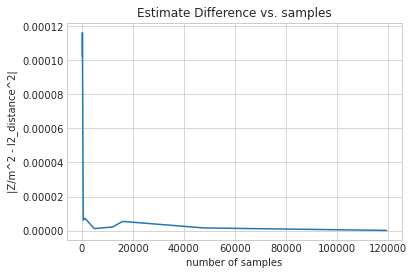

In [158]:
column_names = ['Z/m^2', 'l2_norm^2', 'e^2', 'num samples']
df = pd.DataFrame(results, columns=column_names)
df['difference'] = (df['Z/m^2'] - df['l2_norm^2']).abs()
df['num samples'] = df['num samples'].astype(int)
df['log_samples'] = np.log10(df['num samples'])
print(df)

import matplotlib.pyplot as plt
# fig = plt.figure()
plt.title('Estimate Difference vs. samples')
plt.xlabel('number of samples')
plt.ylabel('|Z/m^2 - l2_distance^2|')
plt.style.use('seaborn-whitegrid')
plt.plot(list(df['num samples']), list(df['difference']))

In [ ]:
# check different values of epsilon for 2009_02 vs 2009_03



In [130]:
data = [d_2009_04, d_2009_03, d_2009_02, d_2009_01, d_2008_12, d_2008_11, d_2008_10, d_2008_09, d_2008_08]
results = []
for i in range(len(data)-1):
    estimated_l2_norm_squared, actual_l2_norm_squared, e_squared = l2_norm_estimate(data[i], data[i+1])
    print(estimated_l2_norm_squared, actual_l2_norm_squared, e_squared)
    results.append([namestr(data[i]), namestr(data[i+1]), estimated_l2_norm_squared, actual_l2_norm_squared, e_squared])
print(results)

old m is:  0.0016075217908926016
new m is:  288243.51
1.2109143905843852e-05 1.1879927181132028e-05 2.8090473149380366
old m is:  0.001618718695453363
new m is:  241876.90999999997
1.291098599146802e-05 1.2673654922148606e-05 2.7896165885891566
old m is:  0.0016336480350448222
new m is:  168493.39
2.247853099064514e-05 2.265890534633373e-05 3.033830735331607
old m is:  0.002092493127613953
new m is:  116208.87
2.0535374866247553e-05 2.0699961822194534e-05 2.787163384882529
old m is:  0.0020754541193632237
new m is:  111533.28
2.3186301640762377e-05 2.4012039055806142e-05 2.810045136207954
old m is:  0.001996936976675037
new m is:  116966.34
2.619156012688461e-05 2.570164907249641e-05 2.8474748050215384
old m is:  0.002196739546606036
new m is:  125700.48999999999
3.421664676095088e-05 3.339045564467001e-05 2.8233628508706783
old m is:  0.002232871809493749
new m is:  119591.79000000001
3.7920749448077764e-05 3.756124469949914e-05 2.7776763650192997
[['d_2009_04', 'd_2009_03', 1.2109143

In [131]:
for i in range(len(results)):
    for j in range(len(results[0])):
        val = str(results[i][j])
        if j>1:
            results[i][j] = val[:5]+'e-05'
column_names = ['month1', 'month2', 'Z/m^2', 'l2_norm^2', 'e^2']
df = pd.DataFrame(results, columns=column_names)
print(df)

      month1     month2      Z/m^2  l2_norm^2        e^2
0  d_2009_04  d_2009_03  1.210e-05  1.187e-05  2.809e-05
1  d_2009_03  d_2009_02  1.291e-05  1.267e-05  2.789e-05
2  d_2009_02  d_2009_01  2.247e-05  2.265e-05  3.033e-05
3  d_2009_01  d_2008_12  2.053e-05  2.069e-05  2.787e-05
4  d_2008_12  d_2008_11  2.318e-05  2.401e-05  2.810e-05
5  d_2008_11  d_2008_10  2.619e-05  2.570e-05  2.847e-05
6  d_2008_10  d_2008_09  3.421e-05  3.339e-05  2.823e-05
7  d_2008_09  d_2008_08  3.792e-05  3.756e-05  2.777e-05


In [128]:
data = [d_2009_04, d_2009_03, d_2009_02, d_2009_01, d_2008_12, d_2008_11, d_2008_10, d_2008_09, d_2008_08]
results = []
for i in range(len(data)-4):
    estimated_l2_norm_squared, actual_l2_norm_squared, e_squared = l2_norm_estimate(data[i], data[i+4])
    print(estimated_l2_norm_squared, actual_l2_norm_squared, e_squared)
    results.append([namestr(data[i]), namestr(data[i+4]), estimated_l2_norm_squared, actual_l2_norm_squared, e_squared])
print(results)

old m is:  0.0012290336098965216
new m is:  266180.26
1.1127487860188474e-05 1.117346582238498e-05 3.0196365220554187
old m is:  0.001486393292419122
new m is:  190556.64
3.453375648481544e-05 3.476408931648652e-05 3.3343902021314733
old m is:  0.0017972108109028011
new m is:  167529.13999999998
3.662586521241829e-05 3.557513166211156e-05 3.2451004907622596
old m is:  0.0016929512652262434
new m is:  112497.52
2.705501997311572e-05 2.7702843541189245e-05 3.1130144940047733
old m is:  0.0018743191109743236
new m is:  120677.68999999999
3.1554122853587055e-05 3.168255642519473e-05 3.1115942540969677
old m is:  0.0020079454589661096
new m is:  116556.06999999999
3.5205507830414255e-05 3.637626144427983e-05 3.0888237721185114
old m is:  0.0019281143764288363
new m is:  120002.06
3.38591152715087e-05 3.5682000787009e-05 3.062876337239628
[['d_2009_04', 'd_2009_02', 1.1127487860188474e-05, 1.117346582238498e-05, 3.0196365220554187], ['d_2009_03', 'd_2009_01', 3.453375648481544e-05, 3.4764089

In [129]:
for i in range(len(results)):
    for j in range(len(results[0])):
        if j>1:
            val = str(results[i][j])
            results[i][j] = val[:5]+'e-05'
column_names = ['month1', 'month2', 'Z/m^2', 'l2_norm^2', 'e^2']
df = pd.DataFrame(results, columns=column_names)
print(df)

      month1     month2      Z/m^2  l2_norm^2        e^2
0  d_2009_04  d_2009_02  1.112e-05  1.117e-05  3.019e-05
1  d_2009_03  d_2009_01  3.453e-05  3.476e-05  3.334e-05
2  d_2009_02  d_2008_12  3.662e-05  3.557e-05  3.245e-05
3  d_2009_01  d_2008_11  2.705e-05  2.770e-05  3.113e-05
4  d_2008_12  d_2008_10  3.155e-05  3.168e-05  3.111e-05
5  d_2008_11  d_2008_09  3.520e-05  3.637e-05  3.088e-05
6  d_2008_10  d_2008_08  3.385e-05  3.568e-05  3.062e-05


In [52]:
d_p_full = d_2009_02
d_q_full = d_2009_03

d_p_multiple = {key:val for key, val in d_p_full.items() if val > 1}
d_q_multiple = {key:val for key, val in d_q_full.items() if val > 1}
p_total = sum(d_p_multiple.values())
q_total = sum(d_q_multiple.values())

d_p = {key:val/p_total for key, val in d_p_multiple.items()}
d_q = {key:val/q_total for key, val in d_q_multiple.items()}

# print(p_total, q_total)

21981366 26394016


In [67]:
d_p_l2norm = lp_norm(d_p, 2)
d_q_l2norm = lp_norm(d_q, 2)
b = max(d_p_l2norm**2, d_q_l2norm**2)

pq_l4norm = lp_distance(d_p, d_q, 4)
pq_l1norm = lp_distance(d_p, d_q, 1)

# setting error and sample parameters
e = pq_l1norm  # set e to be a factor of l1 distance
m = (b**0.5*pq_l4norm**2/e**4 + b**0.5/e**2)  # set m to be a constant factor

avg_size = (p_total + q_total)//2
c = avg_size/(m*1000)
m *= c

In [68]:
# print(m)
s = np.random.poisson(lam=m)
S_p = random.choices(list(d_p.keys()), weights=d_p.values(), k=s)
S_q = random.choices(list(d_q.keys()), weights=d_q.values(), k=s)

S_p_d = list_to_distribution(S_p)
S_q_d = list_to_distribution(S_q)


<!-- s = np.random.poisson(lam=m)
print(s,'hehe')
S_p = random.choices(list(d_p.keys()), weights=d_p.values(), k=s)
S_q = random.choices(list(d_q.keys()), weights=d_q.values(), k=s) -->

In [69]:
Z = 0
for i in S_p_d:
    if i in S_q_d:
        Z += (S_p_d[i]-S_q_d[i])**2-S_p_d[i]-S_q_d[i]
    else:
        Z += S_p_d[i]**2-S_p_d[i]
        
for i in S_q_d:
    if i not in S_p_d:
        Z += S_q_d[i]**2-S_q_d[i]
print(Z)

8158


In [70]:
d_p_l2norm = lp_distance(d_p, d_q, 2)
print(d_p_l2norm**2)
print(Z/(m**2))
print(e**2)
# for i in S_q_d:
#     if i in S_p_d and S_q_d[i] > 1 and S_p_d[i]>1:
#         print(S_q_d[i], S_p_d[i])

# print(S_p)
# print(12)

1.2673654922523615e-05
1.3944240910623699e-05
2.789616588442419


In [ ]:
1.2673654922523615e-05
1.3944240910623699e-05
2.789616588442419

In [7]:
import math

def self_pairwise_collisions(arr):
    collisions = 0
    for i in range(len(arr)-1):
        for j in range(i+1, len(arr)):
            if arr[i] == arr[j]:
                collisions += 1
    return collisions


def across_list_collisions(arr1, arr2):
    collisions = 0
    for i in arr1:
        for j in arr2:
            if i == j:
                collisions += 1
    return collisions

def l2_distance_tester(p, q, m, e, delta):
    num_reject = 0 
    m = round(m)
    rounds = round(math.log(1/delta)) # rounds is O(log(1/delta))
    for _ in range(rounds):
        F_p = random.choices(list(p.keys()), weights=p.values(), k=m)
        F_q = random.choices(list(q.keys()), weights=q.values(), k=m)
        r_p = self_pairwise_collisions(F_p)
        r_q = self_pairwise_collisions(F_q)
        
        Q_p = random.choices(list(p.keys()), weights=p.values(), k=m)
        Q_q = random.choices(list(q.keys()), weights=q.values(), k=m)
        s_pq = across_list_collisions(Q_p, Q_q)
        
        r = 2*m/(m-1)*(r_p+r_q)
        s = 2*s_pq
        if r-s > 3*m**2*e**2/4:
            num_reject += 1
    
    if num_reject >= rounds/2:
        return 0
    return 1

def sampling_distribution_prime(p, domain, sampled_set, m):
    result = []
    for i in range(m):
        sample = random.choices(list(p.keys()), weights=p.values(), k=1)[0]
        if sample not in sampled_set:
            result.append(sample)
        else:
            result.append(random.sample(domain, 1)[0])
    return list_to_distribution(result)

In [8]:
def l1_distance_tester(p, q, e, delta, samples = 100):
    domain = set(p.keys()).intersection(q.keys())
    n = len(domain)
    b = (e/n)**(2/3)
#     print(n,e,delta)
#     m = e**(-8/3)*n**(2/3)*math.log(n/delta) #m is O of this
#     print("yoyoyo m", m)
#     m = int(m*100000)
    m = samples
    print("m is:", m)
    S_p = random.choices(list(p.keys()), weights=p.values(), k=m)
    S_q = random.choices(list(q.keys()), weights=q.values(), k=m)
    
    S_p_d = list_to_distribution(S_p)
    S_q_d = list_to_distribution(S_q)
    threshold = (1-e/26)*m*b
    for word in list(S_p_d.keys()):
        if S_p_d[word] < threshold:
            del S_p_d[word]
    for word in list(S_q_d.keys()):
        if S_q_d[word] < threshold:
            del S_q_d[word]
    
    print("hehehehe")
            
    m_ = n**(2/3)/e**(8/3) # O of this
    e_ = e/(2*n**0.5)
    delta_ = delta/2
    if len(S_p_d) == 0 and len(S_q_d) == 0:
        return l2_distance_tester(p, q, m_, e_, delta_)
    
    if lp_distance(S_p_d, S_q_d, 1) > e*m/8:
        return 0

    sampled_set = set(S_p).intersection(set(S_q))
    p_prime = sampling_distribution_prime(p, domain, sampled_set, m)
    q_prime = sampling_distribution_prime(q, domain, sampled_set, m)
    
    return l2_distance_tester(p_prime, q_prime, m_, e_, delta_)


In [10]:
d_p_full = d_2008_11
d_q_full = d_2008_12

d_p_multiple = {key:val for key, val in d_p_full.items() if val > 1}
d_q_multiple = {key:val for key, val in d_q_full.items() if val > 1}
p_total = sum(d_p_multiple.values())
q_total = sum(d_q_multiple.values())

d_p = {key:val/p_total for key, val in d_p_multiple.items()}
d_q = {key:val/q_total for key, val in d_q_multiple.items()}

l1_distance = lp_distance(d_p, d_q, 1)
# print(l1_norm)

In [11]:
delta = 0.1
e = l1_distance*250
domain = set(d_p.keys()).intersection(d_q.keys())
n = len(domain)

a=(e**(4/3)/(32*n**(1/3)))
b=(e/(4*n**0.5))
print(n)
print(a,b,max(a,b), e)


169430
1.7711232879509458 0.25453148413836607 1.7711232879509458 419.07973109559765


In [14]:
# print(d_p_full)
delta = 0.75
# e = l1_norm/2

# print(l1_distance_tester(d_p, d_q, e, delta))
# count = 0
# for i in range(100):
#     if i%10==0:
#         print(i, count)
#     count+=l1_distance_tester(d_p, d_q, e, delta)
# print("result:", count)


result = {}
# m_test = [10, 25, 50, 75, 100, 150, 200, 400, 800, 1600]
m_test = [3200, 6400]
for m in m_test:
#     print(m)
    total_time = 0
    for i in range(1):
        start_time = time.time()
        l1_distance_tester(d_p, d_q, e, delta, samples=m)
        time_used = time.time() - start_time
        total_time += time_used
    avg_time = total_time/3
    result[m] = avg_time
    print(m, avg_time)

m is: 3200
hehehehe
3200 390.1798982620239
m is: 6400
hehehehe
6400 780.3905648390452


In [13]:
print(result)

{10: 1.9047253926595051, 25: 3.434788386027018, 50: 6.353319883346558, 75: 10.648356358210245, 100: 12.935736020406088, 150: 18.945610920588177, 200: 27.562667449315388, 400: 50.68171199162801, 800: 104.46039350827535, 1600: 199.97429958979288}


In [ ]:
# S_p = {i:S_p.count(i) for i in np.unique(S_p)}
# S_q = {i:S_q.count(i) for i in np.unique(S_q)}

# reservoir sampling
S_p = []
count = 0
for phrase in d_p:
    for _ in range(len(d_p[phrase])):
        if count%10000000 == 0:
            print(count)
        count += 1
        if len(S_p) < s:
            S_p.append(word)
        else:
            pos = random.randrange(0, count) 
            if pos < s:
                S_p[pos] = word
print(S_p)


In [38]:
print(len(S_q_d), len(S_p_d))

239498 240679


<BarContainer object of 2011696 artists>

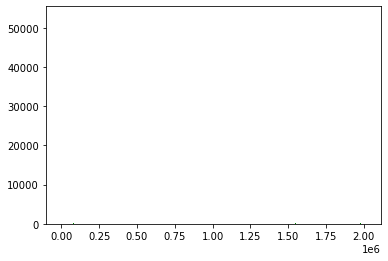

In [59]:
import numpy as np 
import matplotlib.pyplot as plt

phrases = []
for x in list(d.values()):
    if x>2:
        phrases.append(x)
# phrases = [x if x>2 for x in list(d.values())]
plt.bar([x for x in range(len(phrases))], phrases, color='g')


In [ ]:
# import time
# start_time = time.time()


# # {date:word:count}
# d = {}
# count = 0
# with open('quotes_2009-03.txt', 'r') as file:
#     curr_date = None 
#     for line in file:
# #         if count%1000000 == 0:
# #             print(count)
# #         count+=1
#         if line[0] == 'T':
#             curr_date = line.split()[1]
#         if line[0] == 'Q':
#             if curr_date not in d:
#                 d[curr_date] = {}
#             for word in line.split()[1:]:
#                 if word in d[curr_date]:
#                     d[curr_date][word] += 1
#                 else:
#                     d[curr_date][word] = 1
                    
# print("--- %s seconds ---" % (time.time() - start_time))

# import time
# start_time = time.time()
# d = {}
# count = 0
# with open('quotes_2009-03.txt', 'r') as file:
#     curr_date = None 
#     for line in file:
#         if count%1000000 == 0:
#             print(count)
#         count+=1
#         if line[0] == 'T':
#             curr_date = line.split()[1]
#         if line[0] == 'Q':
#             if curr_date not in d:
#                 d[curr_date] = {}
#             phrase = line.split('Q')[1].lstrip()
# #             print(phrase)
# #             import sys
# #             sys.exit()
#             if phrase in d[curr_date]:
#                 d[curr_date][phrase]+=1
#             else:
#                 d[curr_date][phrase]=1
# #             for word in line.split()[1:]:
# #                 if word in d[curr_date]:
# #                     d[curr_date][word] += 1
# #                 else:
# #                     d[curr_date][word] = 1
# print("--- %s seconds ---" % (time.time() - start_time))